# **Train fact verification model**

### **Imports**

In [1]:
# Functions from my other script:
from fact_ver import *
# Other packages:
import numpy as np
import pandas as pd

### **Read generated data**

In [2]:
generated_statements = pd.read_csv("generated_statements.csv")
generated_statements.head()

,Title,Article,Summary,Statement,Label
0,USS SC-40,"USS SC-40, until July 1920 known as USS Submar...","USS SC-40, until July 1920 known as USS Submar...",USS SC-40 was a wooden-hulled submarine chaser.,1
1,Valentina Zenere,Valentina Zenere (born 15 January 1997) is an...,Valentina Zenere (born 15 January 1997) is an...,Valentina Zenere plays Isadora Artiñán on Elite.,1
2,From M.E. to Myself,From M.E. to Myself (simplified Chinese: 和自己对话...,From M.E. to Myself (simplified Chinese: 和自己对话...,Golden Melody Awards for Best Mandarin Male Si...,1
3,Charalampos Papaioannou,"Charalampos Papaioannou (born January 4, 1971)...","Charalampos Papaioannou (born January 4, 1971)...",Charalampos Papaioannou is a Greek judoka.,1
4,"First United Methodist Church (Aberdeen, South...",Aberdeen First United Methodist Church is a hi...,Aberdeen First United Methodist Church is a hi...,The church features an open lantern atop the r...,1


### **Split data**

In [3]:
train_data, val_test_data = train_test_split(generated_statements, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(val_test_data, test_size=1/3, random_state=42)
print(f"-> Train shape: {train_data.shape}")
print(f"-> Val shape:   {val_data.shape}")
print(f"-> Test shape:  {test_data.shape}")

-> Train shape: (1400, 5)
-> Val shape:   (400, 5)
-> Test shape:  (200, 5)


### **Extract word embeddings**

In [4]:
evidence_train = extract_embedding(train_data["Summary"], 127).numpy()
evidence_val = extract_embedding(val_data["Summary"], 127).numpy()
evidence_test = extract_embedding(test_data["Summary"], 127).numpy()

claim_train = extract_embedding(train_data["Statement"], 27).numpy()
claim_val = extract_embedding(val_data["Statement"], 27).numpy()
claim_test = extract_embedding(test_data["Statement"], 27).numpy()

y_train = train_data["Label"]
y_val = val_data["Label"]
y_test = test_data["Label"]

In [5]:
print(f"-> Labels shape:   {y_test.shape}")
print(f"-> Claim shape:    {claim_test.shape}")
print(f"-> Evidence shape: {evidence_test.shape}")

-> Labels shape:   (200,)
-> Claim shape:    (200, 27, 512)
-> Evidence shape: (200, 127, 512)


### **Build model**

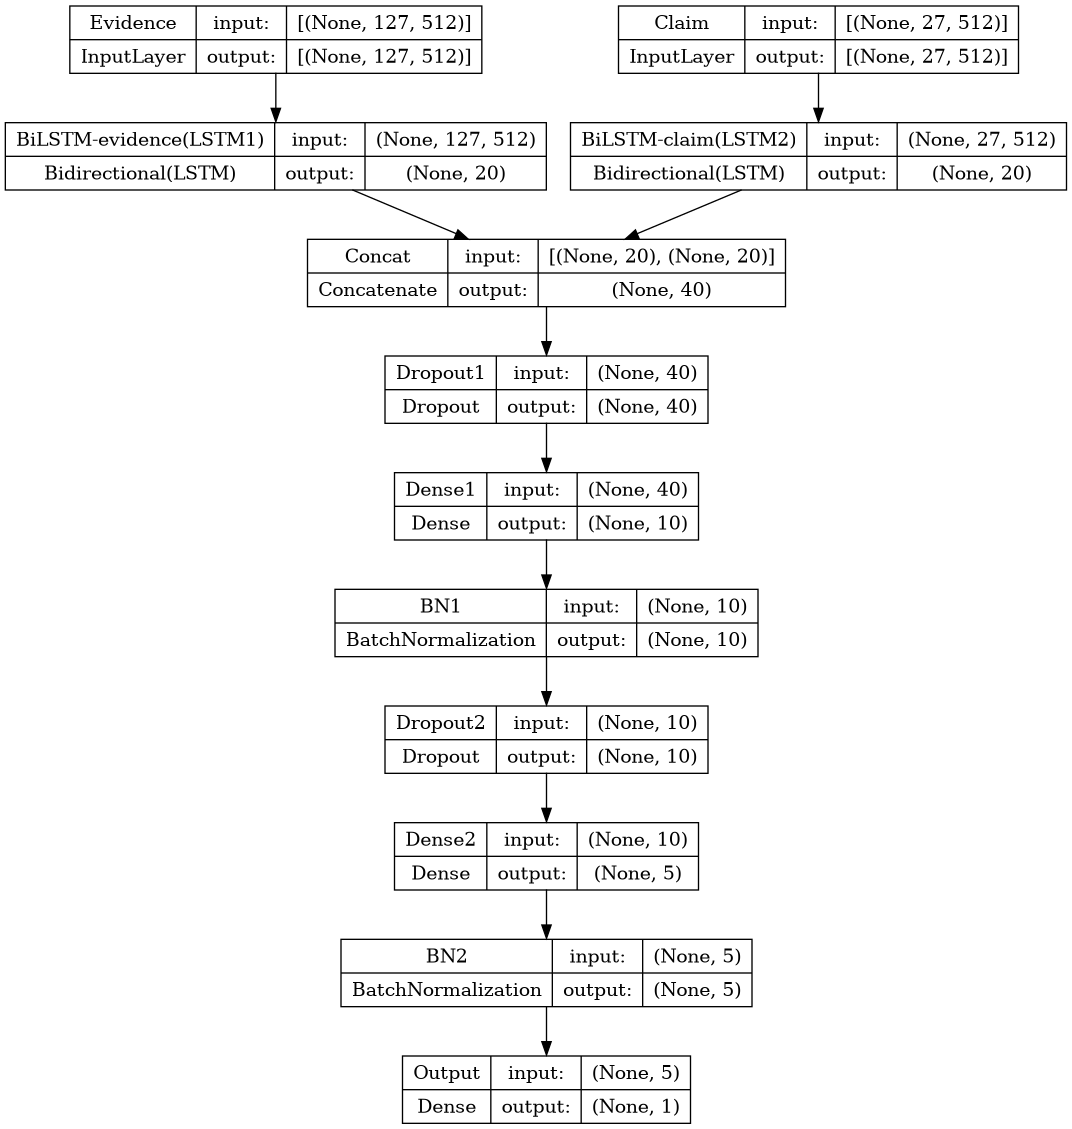

In [6]:
model = build_model(n_LSTM_ev=10, RET_SEQ_ev=False, n_LSTM_cl=10, RET_SEQ_cl=False,      # LSTM-parametrs
                    L2_REG=0.001, DROPOUT_rec=0.2, DROPOUT_RATE1=0.5, DROPOUT_RATE2=0.5, # Regularization parametrs (LSTM & Dense)
                    n_DENSE1=10, n_DENSE2=5)                                            # Dense parametrs
plot_model(model, to_file="model_architecture.png", show_shapes=True, show_layer_names=True)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Evidence (InputLayer)       [(None, 127, 512)]           0         []                            
                                                                                                  
 Claim (InputLayer)          [(None, 27, 512)]            0         []                            
                                                                                                  
 BiLSTM-evidence (Bidirecti  (None, 20)                   41840     ['Evidence[0][0]']            
 onal)                                                                                            
                                                                                                  
 BiLSTM-claim (Bidirectiona  (None, 20)                   41840     ['Claim[0][0]']           

### **Fit model**

In [8]:
history, model = fit_model(model, LR=0.0005, BS=32,
                           claim_train=claim_train,
                           evidence_train=evidence_train,
                           y_train=y_train,
                           claim_val=claim_val,
                           evidence_val=evidence_val,
                           y_val=y_val)

Epoch 1/200
44/44 [==============================] - ETA: 0s - loss: 1.2466 - accuracy: 0.4900
Epoch 1: val_loss improved from inf to 1.04043, saving model to FactVerModel
44/44 [==============================] - 28s 449ms/step - loss: 1.2466 - accuracy: 0.4900 - val_loss: 1.0404 - val_accuracy: 0.5850
Epoch 2/200
44/44 [==============================] - ETA: 0s - loss: 1.1543 - accuracy: 0.5457
Epoch 2: val_loss improved from 1.04043 to 1.03666, saving model to FactVerModel
44/44 [==============================] - 18s 426ms/step - loss: 1.1543 - accuracy: 0.5457 - val_loss: 1.0367 - val_accuracy: 0.5575
Epoch 3/200
44/44 [==============================] - ETA: 0s - loss: 1.1081 - accuracy: 0.5493
Epoch 3: val_loss improved from 1.03666 to 1.00211, saving model to FactVerModel
44/44 [==============================] - 19s 428ms/step - loss: 1.1081 - accuracy: 0.5493 - val_loss: 1.0021 - val_accuracy: 0.6150
Epoch 4/200
44/44 [==============================] - ETA: 0s - loss: 1.0477 - ac

## **Evaluate model**

In [9]:
loss, acc = model.evaluate([claim_val, evidence_val], y_val)
print(acc)

13/13 [==============================] - 1s 25ms/step - loss: 0.6596 - accuracy: 0.8025
0.8025000095367432


Lowest validation loss at epoch: 33


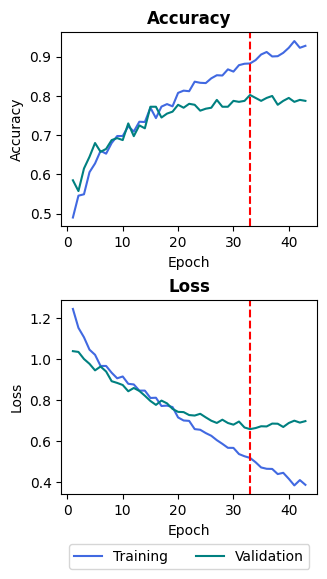

In [10]:
plot_training_history(history)

## **Train report**

In [11]:
predictions = model.predict([claim_train, evidence_train])
y_pred = (predictions > 0.5).astype(int)
report = classification_report(y_train, y_pred)
print(report)

44/44 [==============================] - 2s 25ms/step
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       702
           1       0.97      0.95      0.96       698

    accuracy                           0.96      1400
   macro avg       0.96      0.96      0.96      1400
weighted avg       0.96      0.96      0.96      1400



## **Validation report**

In [12]:
predictions = model.predict([claim_val, evidence_val])
y_pred = (predictions > 0.5).astype(int)
report = classification_report(y_val, y_pred)
print(report)

13/13 [==============================] - 0s 24ms/step
              precision    recall  f1-score   support

           0       0.80      0.79      0.79       192
           1       0.81      0.82      0.81       208

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



## **Test report**

In [13]:
predictions = model.predict([claim_test, evidence_test])
y_pred = (predictions > 0.5).astype(int)
report = classification_report(y_test, y_pred)
print(report)

7/7 [==============================] - 0s 25ms/step
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       106
           1       0.80      0.90      0.85        94

    accuracy                           0.85       200
   macro avg       0.85      0.85      0.85       200
weighted avg       0.86      0.85      0.85       200

